<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#一-导包并读取数据" data-toc-modified-id="一-导包并读取数据-1">一 导包并读取数据</a></span><ul class="toc-item"><li><span><a href="#1-查看数据规模" data-toc-modified-id="1-查看数据规模-1.1">1 查看数据规模</a></span></li><li><span><a href="#2-不同特征组" data-toc-modified-id="2-不同特征组-1.2">2 不同特征组</a></span></li></ul></li><li><span><a href="#二-所有特征在两个类别上的散点图" data-toc-modified-id="二-所有特征在两个类别上的散点图-2">二 所有特征在两个类别上的散点图</a></span><ul class="toc-item"><li><span><a href="#1-阈值是向上取整得到的整数" data-toc-modified-id="1-阈值是向上取整得到的整数-2.1">1 阈值是向上取整得到的整数</a></span></li></ul></li><li><span><a href="#三-查看重点特征并检查阈值" data-toc-modified-id="三-查看重点特征并检查阈值-3">三 查看重点特征并检查阈值</a></span><ul class="toc-item"><li><span><a href="#规则1-power和wind_speed：16588" data-toc-modified-id="规则1-power和wind_speed：16588-3.1">规则1 power和wind_speed：16588</a></span></li><li><span><a href="#规则2-environment_tmp：2555" data-toc-modified-id="规则2-environment_tmp：2555-3.2">规则2 environment_tmp：2555</a></span></li><li><span><a href="#规则3-pitch1/2/3_moto_tmp：10871" data-toc-modified-id="规则3-pitch1/2/3_moto_tmp：10871-3.3">规则3 pitch1/2/3_moto_tmp：10871</a></span></li><li><span><a href="#规则4-pitch1/2/3/mean_angle：12530" data-toc-modified-id="规则4-pitch1/2/3/mean_angle：12530-3.4">规则4 pitch1/2/3/mean_angle：12530</a></span></li></ul></li><li><span><a href="#四-所有规则总结" data-toc-modified-id="四-所有规则总结-4">四 所有规则总结</a></span></li><li><span><a href="#五-效果" data-toc-modified-id="五-效果-5">五 效果</a></span><ul class="toc-item"><li><span><a href="#1-被过滤部分得分——#15的训练集和测试集" data-toc-modified-id="1-被过滤部分得分——#15的训练集和测试集-5.1">1 被过滤部分得分——#15的训练集和测试集</a></span></li><li><span><a href="#2-不采用过滤手段" data-toc-modified-id="2-不采用过滤手段-5.2">2 不采用过滤手段</a></span></li><li><span><a href="#3-使用过滤后" data-toc-modified-id="3-使用过滤后-5.3">3 使用过滤后</a></span></li><li><span><a href="#4-前后对比" data-toc-modified-id="4-前后对比-5.4">4 前后对比</a></span></li></ul></li></ul></div>

公共强规则过滤的部分先不用比较得分，因为不管用什么模型这部分的得分都一样，只要详细比较模型处理数据那部分得分，然后简略汇报总得分即可

还是希望能从不同角度过滤出不一样的样本

# 一 导包并读取数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

plt.rcParams['font.family']=['Songti SC']
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows = 200

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=100, suppress=True)

In [2]:
# 读入文件
# 15号风机数据
new15 = pd.read_csv("../data/15-new.csv",index_col=0).round(2)
new15.rename(columns={'wind_speed/power':'wind_speed.div.power', 'power/generator_speed':'power.div.generator_speed','generator_speed/wind':'generator_speed.div.wind'},inplace=True)
# 21号风机数据
new21 = pd.read_csv("../data/21-new.csv",index_col=0).round(2)
new21.drop(columns=['Unnamed: 0.1'],inplace=True)
new21.rename(columns={"Label": "label",'wind_speed/power':'wind_speed.div.power', 'power/generator_speed':'power.div.generator_speed','generator_speed/wind':'generator_speed.div.wind'},inplace=True)

## 1 查看数据规模

In [3]:
new15.shape[0]

373696

In [4]:
new21.shape[0]

177591

## 2 不同特征组

In [5]:
# 选出的12个特征
feature_selected = ['environment_tmp', 'int_tmp','yaw_speed','wind_speed','pitch3_moto_tmp','pitch1_moto_tmp','pitch2_moto_tmp',
'power','pitch1_angle','pitch3_angle','pitch2_angle','generator_speed']

In [6]:
# 新生成的5个特征
feature_gen = ['wind_speed.div.power', 'power.div.generator_speed','generator_speed.div.wind', 'mean_pitch_angle', 'tmp_diff']

In [7]:
# 26个原始特征 + 新生成的5个特征
feature_all = new15.columns.drop("label").to_list()

In [8]:
feature_all

['wind_speed',
 'generator_speed',
 'power',
 'wind_direction',
 'wind_direction_mean',
 'yaw_position',
 'yaw_speed',
 'pitch1_angle',
 'pitch2_angle',
 'pitch3_angle',
 'pitch1_speed',
 'pitch2_speed',
 'pitch3_speed',
 'pitch1_moto_tmp',
 'pitch2_moto_tmp',
 'pitch3_moto_tmp',
 'acc_x',
 'acc_y',
 'environment_tmp',
 'int_tmp',
 'pitch1_ng5_tmp',
 'pitch2_ng5_tmp',
 'pitch3_ng5_tmp',
 'pitch1_ng5_DC',
 'pitch2_ng5_DC',
 'pitch3_ng5_DC',
 'wind_speed.div.power',
 'power.div.generator_speed',
 'generator_speed.div.wind',
 'mean_pitch_angle',
 'tmp_diff']

# 二 所有特征在两个类别上的散点图

In [9]:
# 两个特征分别是x、y轴，
# 左上角的图是结冰数据，左下角的图是非结冰数据
# 右上角的图是将结冰数据和非结冰数据绘制在一张图上，点的某个颜色越深说明在这个位置 这个颜色的点的个数越多
# 右下角的图也是将结冰数据和非结冰数据绘制在一张图上，但是和右上角的图不同，因为右上角的图看不出红色点堆叠处下面是否有蓝点，所以在右下角，我们将点的含义变成存在结冰数据就有红点、存在非结冰数据就有蓝点，而不让蓝点和蓝点、红点和红点堆叠，方便看清红点和蓝点的重叠
def strong_rule_explore_plot(new21,feature_x,feature_y,is_text,x1,y1,x2,y2,is_line,xx1,yy1,xx2,yy2):
    plt.figure(figsize=(10,8))
    plt.subplots_adjust(wspace =0.25, hspace =0.4)

    dict = {0: 'normal', 1:'abnormal'}

    plt.subplot(221)
    plt.scatter(new21[new21.label==1][feature_x],new21[new21.label==1][feature_y],c='red',label='abnormal',alpha=0.1,marker = '.')
    plt.title(f'{feature_x} - {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend(loc='best')
    # plt.xlim(-2,5)
    # plt.ylim(-1.5,2.8)
    plt.grid(True)

    plt.subplot(222)
    for color,labels in [('blue', 0), ('red', 1)]: 
        plt.scatter(new21[new21.label==labels][feature_x],new21[new21.label==labels][feature_y],c=color,label=dict[labels],alpha=0.05,marker = '.')
    plt.title(f'{feature_x} - {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend(loc='best')
    plt.grid(True)

    plt.subplot(223)
    plt.scatter(new21[new21.label==0][feature_x],new21[new21.label==0][feature_y],c='blue',label='normal',alpha=0.1,marker = '.')
    plt.title(f'{feature_x} - {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend(loc='best')
    plt.grid(True)

    plt.subplot(224)
    for color,labels in [('red', 1),('blue', 0)]: 
        print(new21.shape[0])
        df = new21[new21.label==labels][[feature_x,feature_y]].round(1).drop_duplicates()
        print(df.shape[0])
        plt.scatter(df[feature_x],df[feature_y],c=color,label=dict[labels],alpha=0.3,marker = '.')
    plt.title(f'{feature_x} - {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend(loc='best')
    plt.grid(True)
    if is_line:
        # plt.plot([-2,-2.5],[2.5,2])
        plt.plot([xx1,yy1],[xx2,yy2])

    feature_x_max = x=new21[new21.label==1][feature_x].max()
    feature_y_max = x=new21[new21.label==1][feature_y].max()
    plt.axvline(x=feature_x_max, c='green',linestyle='--',alpha=0.8)
    plt.axhline(y=feature_y_max, c='green',linestyle='--',alpha=0.8)
    if is_text:
        plt.text(x=x1, y=y1, s=f"{feature_x} = %.2f" % feature_x_max,va='center',ha='left',size='medium',weight='bold',color="green")
        plt.text(x=x2, y=y2, s=f"{feature_y} = %.2f" % feature_y_max,va='center',ha='left',size='medium',weight='bold',color="green")
    plt.tight_layout()
    plt.savefig(f'./rule/{feature_x}-{feature_y}_{is_text}.png',dpi=200)
    plt.show()
    return feature_x_max,feature_y_max


# 画图的同时，输出具体的点个数
def strong_rule_num(new21,feature_x,feature_y,is_text=False,x1=0,y1=0,x2=1,y2=1,is_line=False,xx1=0,yy1=0,xx2=0,yy2=0):
    feature_x_max,feature_y_max = strong_rule_explore_plot(new21,feature_x,feature_y,is_text,x1,y1,x2,y2,is_line,xx1,yy1,xx2,yy2)
    print(f"{feature_x} > {math.ceil(feature_x_max)}: {new21[new21[feature_x] > math.ceil(feature_x_max)].shape[0]}")
    print(f"{feature_y} > {math.ceil(feature_y_max)}: {new21[new21[feature_y] > math.ceil(feature_y_max)].shape[0]}")
    print(f"{feature_y} > {math.ceil(feature_y_max)} 且 {feature_x} > {math.ceil(feature_x_max)}: {new21[(new21[feature_y] > math.ceil(feature_y_max)) & (new21[feature_x] > math.ceil(feature_x_max))].shape[0]}")

*********************
0 1
373696
372
373696
513


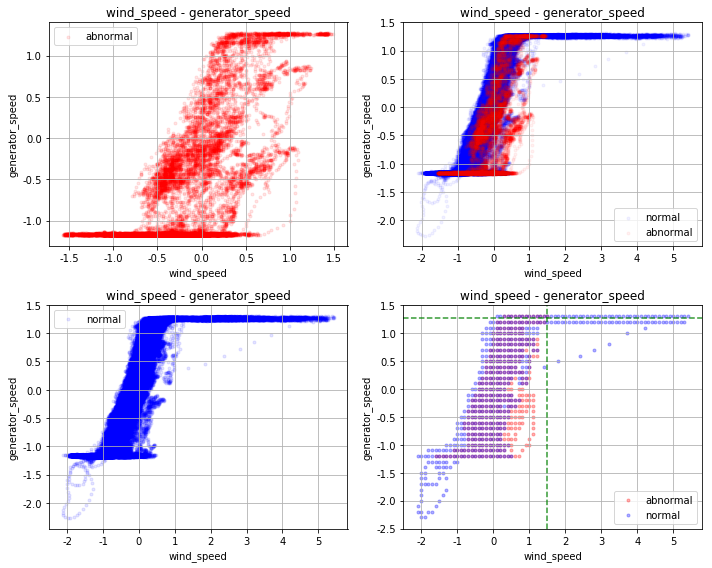

wind_speed > 2: 11503
generator_speed > 2: 0
generator_speed > 2 且 wind_speed > 2: 0
*********************
2 3
373696
1019
373696
2095


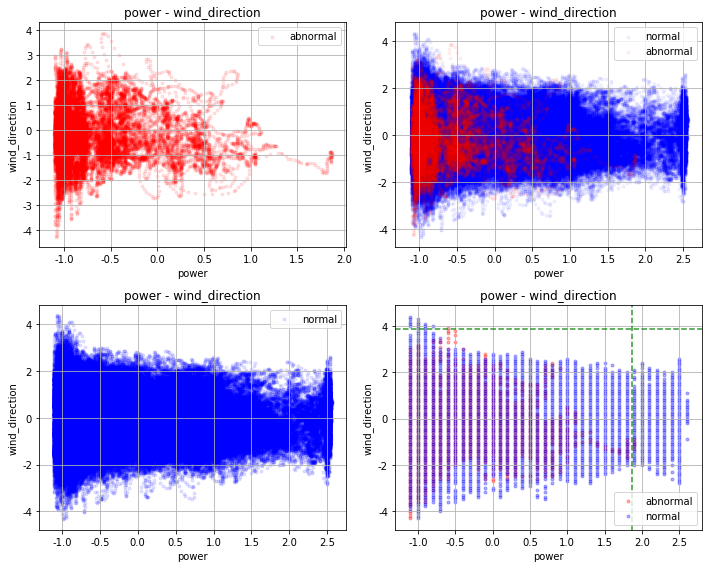

power > 2: 16581
wind_direction > 4: 20
wind_direction > 4 且 power > 2: 0
*********************
4 5
373696
702
373696
2174


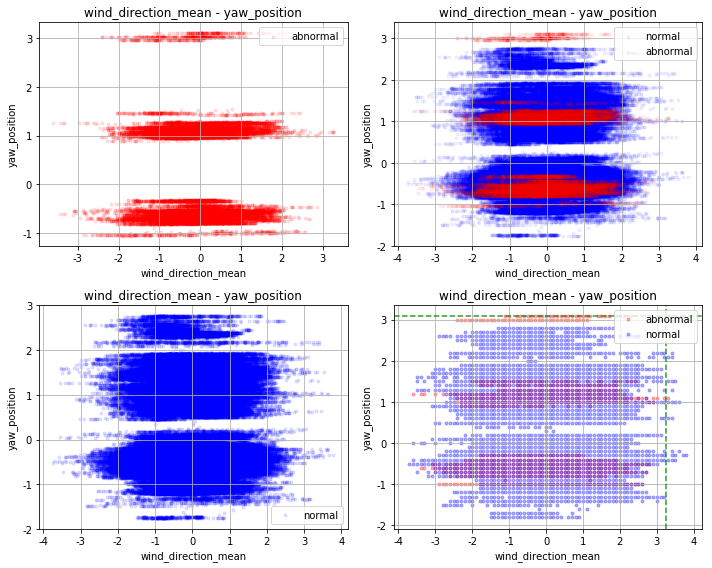

wind_direction_mean > 4: 0
yaw_position > 4: 0
yaw_position > 4 且 wind_direction_mean > 4: 0
*********************
6 7
373696
70
373696
573


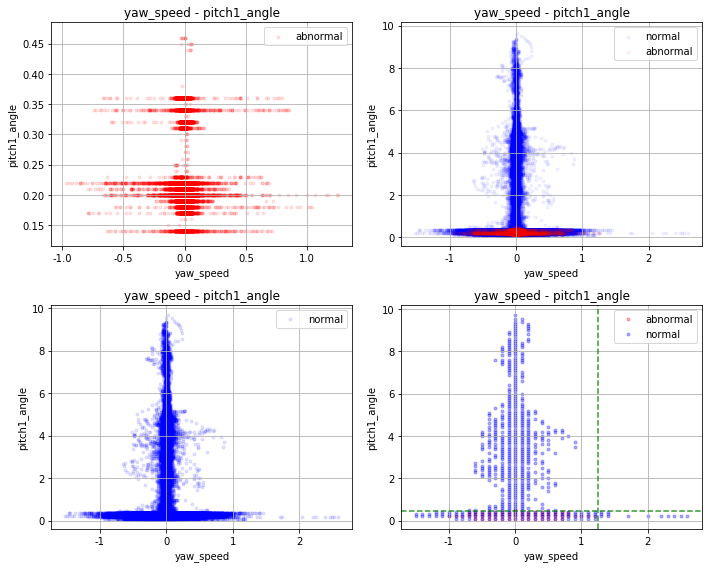

yaw_speed > 2: 8
pitch1_angle > 1: 12525
pitch1_angle > 1 且 yaw_speed > 2: 0
*********************
8 9
373696
7
373696
199


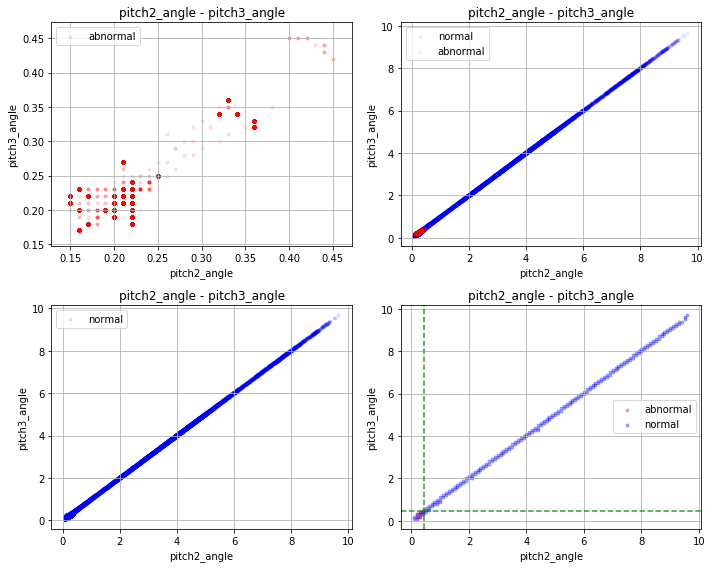

pitch2_angle > 1: 12475
pitch3_angle > 1: 12519
pitch3_angle > 1 且 pitch2_angle > 1: 12474
*********************
10 11
373696
7
373696
234


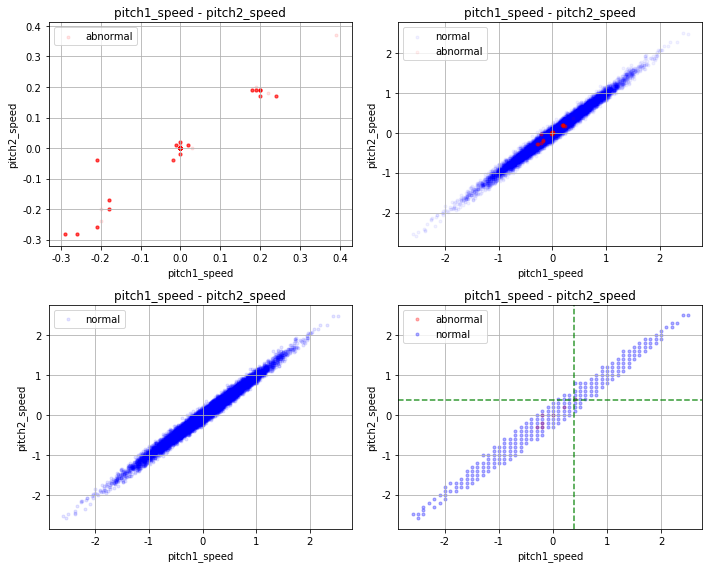

pitch1_speed > 1: 581
pitch2_speed > 1: 586
pitch2_speed > 1 且 pitch1_speed > 1: 515
*********************
12 13
373696
44
373696
848


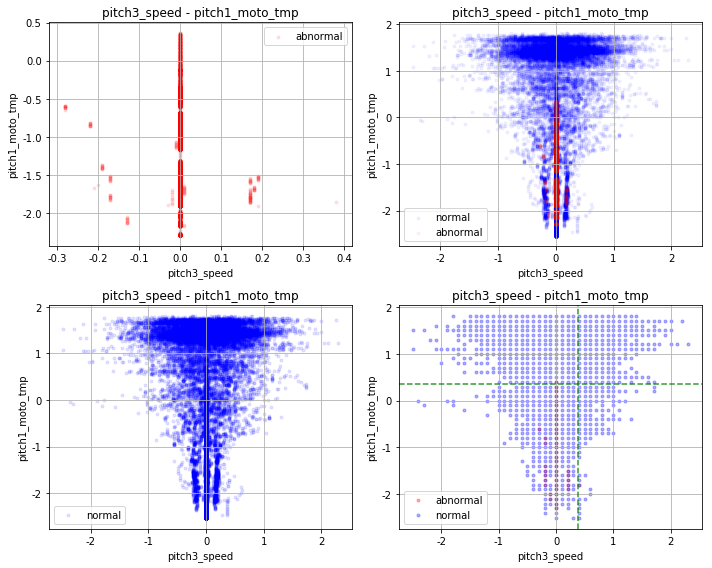

pitch3_speed > 1: 417
pitch1_moto_tmp > 1: 10871
pitch1_moto_tmp > 1 且 pitch3_speed > 1: 344
*********************
14 15
373696
63
373696
168


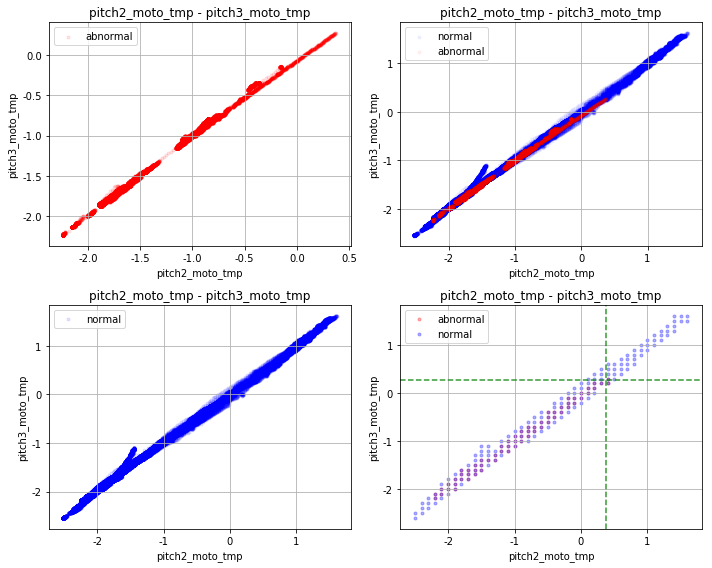

pitch2_moto_tmp > 1: 8039
pitch3_moto_tmp > 1: 8251
pitch3_moto_tmp > 1 且 pitch2_moto_tmp > 1: 7723
*********************
16 17
373696
371
373696
871


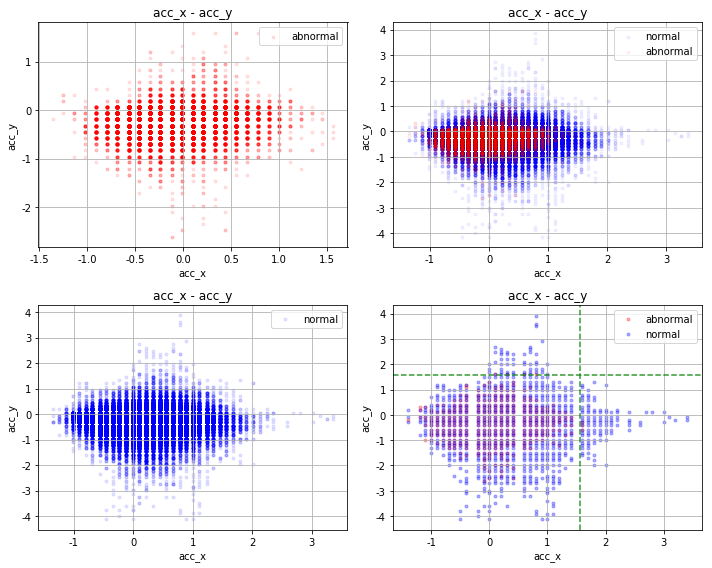

acc_x > 2: 72
acc_y > 2: 26
acc_y > 2 且 acc_x > 2: 0
*********************
18 19
373696
193
373696
678


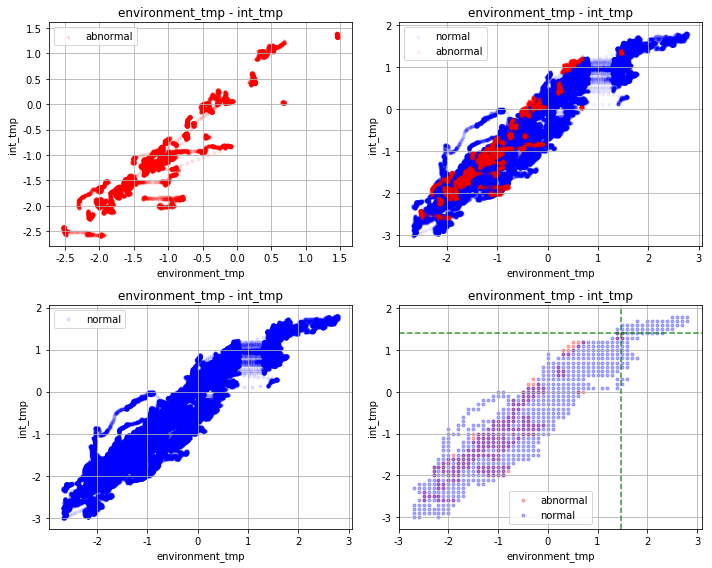

environment_tmp > 2: 2555
int_tmp > 2: 0
int_tmp > 2 且 environment_tmp > 2: 0
*********************
20 21
373696
92
373696
133


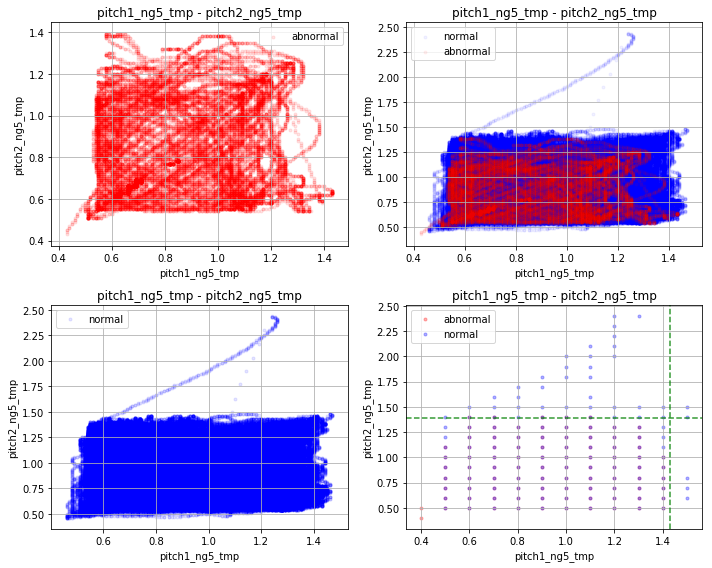

pitch1_ng5_tmp > 2: 0
pitch2_ng5_tmp > 2: 90
pitch2_ng5_tmp > 2 且 pitch1_ng5_tmp > 2: 0
*********************
22 23
373696
242
373696
355


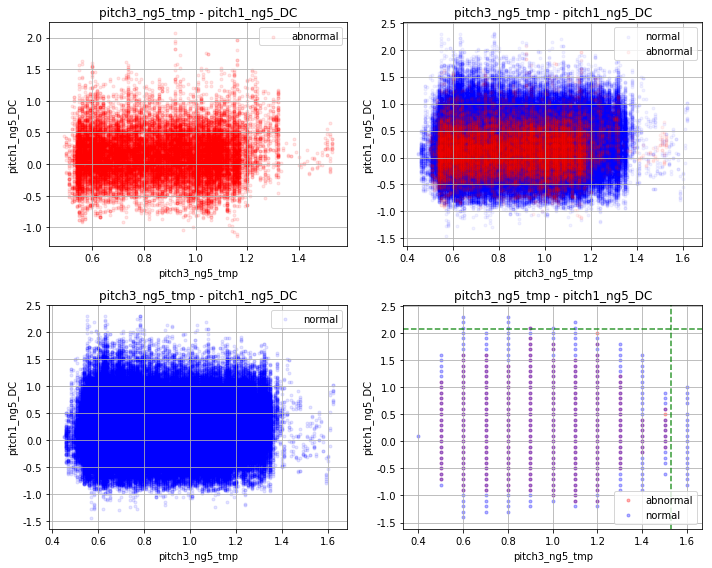

pitch3_ng5_tmp > 2: 0
pitch1_ng5_DC > 3: 0
pitch1_ng5_DC > 3 且 pitch3_ng5_tmp > 2: 0
*********************
24 25
373696
613
373696
1088


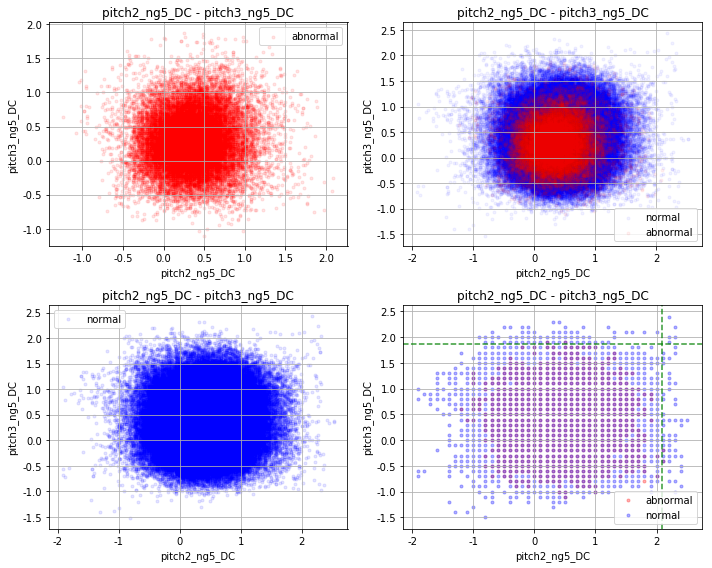

pitch2_ng5_DC > 3: 0
pitch3_ng5_DC > 2: 64
pitch3_ng5_DC > 2 且 pitch2_ng5_DC > 3: 0
*********************
26 27
373696
2093
373696
9093


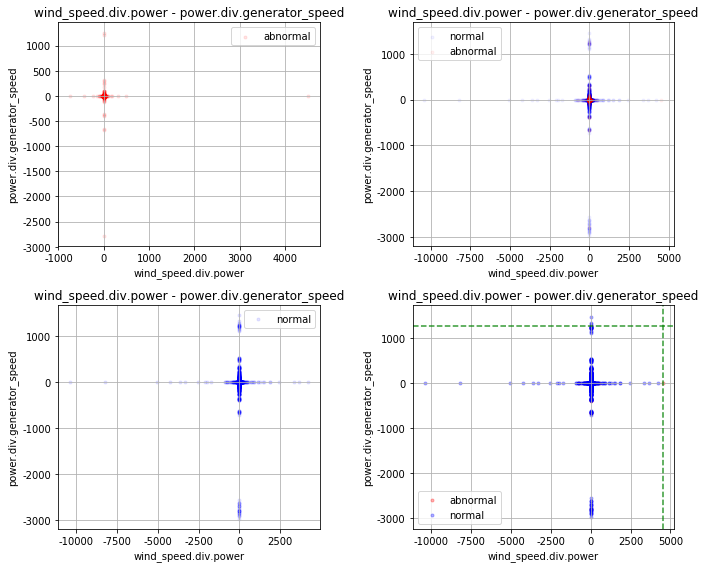

wind_speed.div.power > 4507: 0
power.div.generator_speed > 1260: 4
power.div.generator_speed > 1260 且 wind_speed.div.power > 4507: 0
*********************
28 29
373696
1822
373696
4686


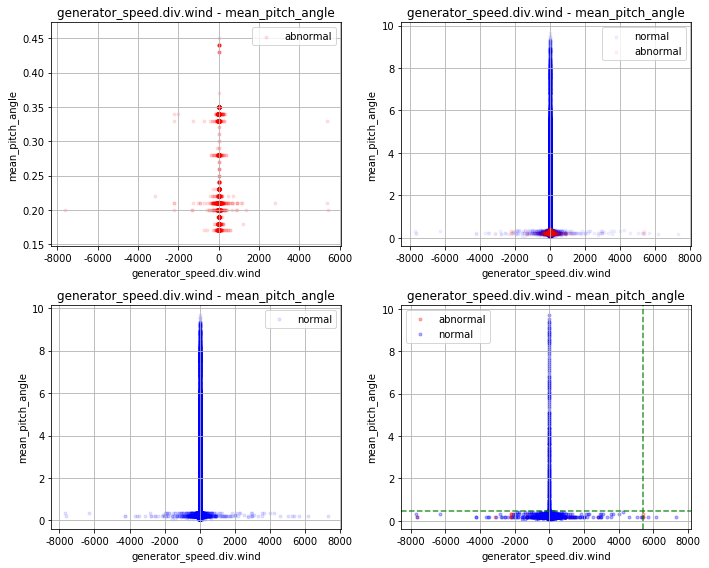

generator_speed.div.wind > 5410: 3
mean_pitch_angle > 1: 12510
mean_pitch_angle > 1 且 generator_speed.div.wind > 5410: 0


In [10]:
for i in range(1,int(len(feature_all)/2)+1):
    print("*********************")
    print(i*2-2,i*2-1)
    strong_rule_num(new21=new15,feature_x=feature_all[i*2-2],feature_y=feature_all[i*2-1])

## 1 阈值是向上取整得到的整数

下面列举了筛选个数较多(>1000)的强规则：

- power > 2: 16581
- 12000个
    - pitch1_angle > 1: 12525
    - pitch2_angle > 1: 12475
    - pitch3_angle > 1: 12519
    - mean_pitch_angle > 1: 12510
- wind_speed > 2: 11503
- 10000个
    - pitch1_moto_tmp > 1: 10871
    - pitch2_moto_tmp > 1: 8039
    - pitch3_moto_tmp > 1: 8251
- environment_tmp > 2: 2555

接下来  
一是对可剔除个数较多的特征进行仔细查看，并检查阈值是否合适  
二是对在二维图形上可人为划分的进行划分

# 三 查看重点特征并检查阈值
重点的意思是：
- 可剔除样本个数较多

## 规则1 power和wind_speed：16588
由下图可得两条强规则：
- power > 2(1.87)一定是不结冰：16581
- wind_speed > 2(1.49)一定是不结冰：11503

In [11]:
new15[(new15['wind_speed']>2) | (new15['power']>2)].shape[0]

16588

373696
335
373696
567


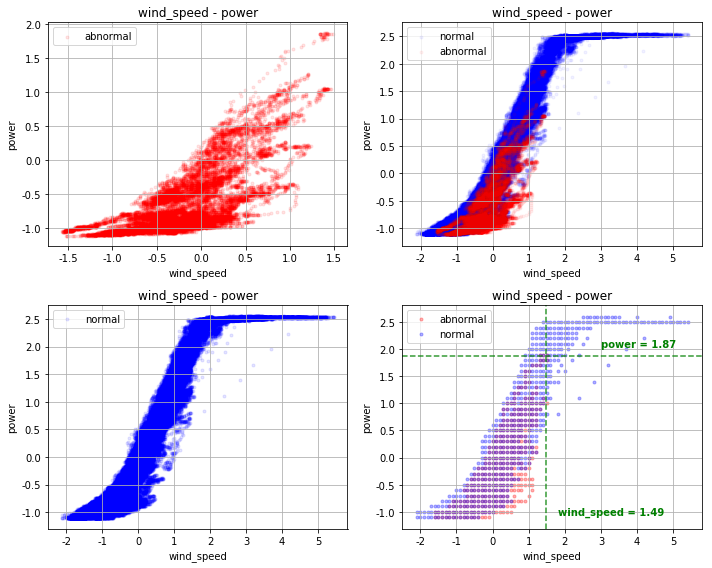

wind_speed > 2: 11503
power > 2: 16581
power > 2 且 wind_speed > 2: 11496


In [12]:
strong_rule_num(new15,'wind_speed','power',True,1.8,-1,3,2.1)

## 规则2 environment_tmp：2555
- environment_tmp > 2(1.47)一定是不结冰

In [13]:
new15[(new15['environment_tmp']>2)].shape[0]

2555

373696
193
373696
678


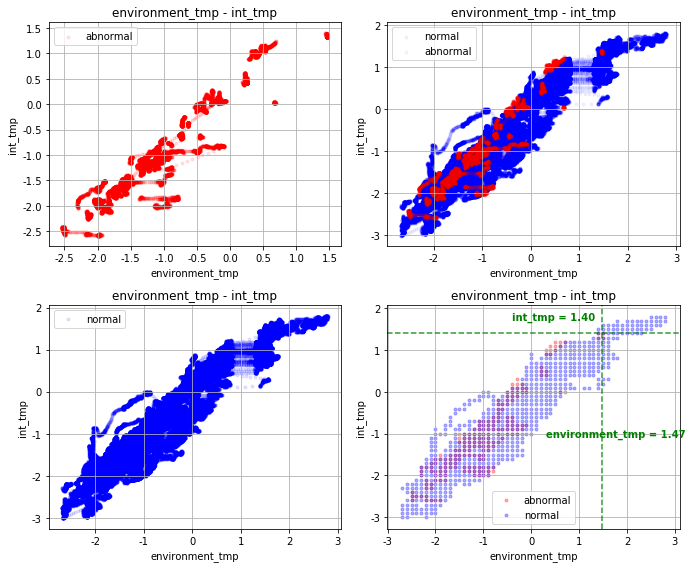

environment_tmp > 2: 2555
int_tmp > 2: 0
int_tmp > 2 且 environment_tmp > 2: 0


In [14]:
strong_rule_num(new15,'environment_tmp', 'int_tmp',True,0.3,-1,-0.4,1.8)

## 规则3 pitch1/2/3_moto_tmp：10871
- pitch1/2/3_moto_tmp > 1(0.36，0.27) 一定是不结冰

In [15]:
new15[(new15['pitch2_moto_tmp']>1) | (new15['pitch1_moto_tmp']>1) | (new15['pitch3_moto_tmp']>1)].shape[0]

10871

In [16]:
new15[(new15['pitch2_moto_tmp']>1)].shape[0]

8039

In [17]:
new15[(new15['pitch2_moto_tmp']>1)].shape[0] == new15[(new15['pitch2_moto_tmp']>1) & (new15['label']==0)].shape[0]

True

373696
61
373696
196


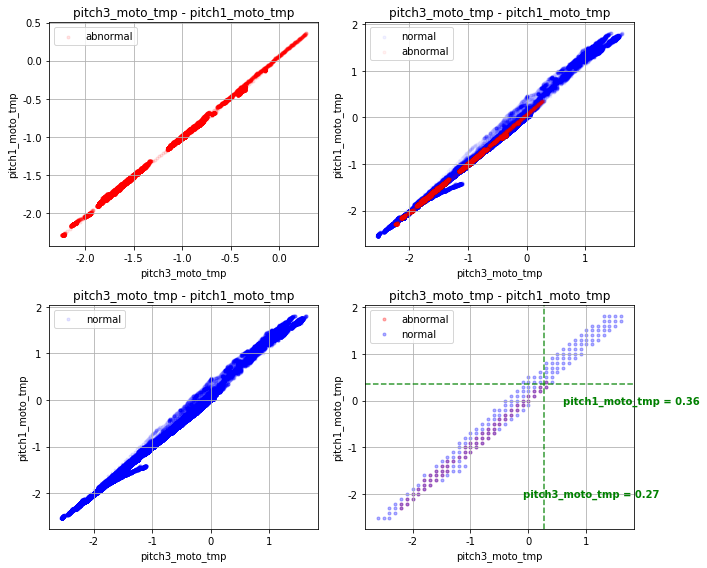

pitch3_moto_tmp > 1: 8251
pitch1_moto_tmp > 1: 10871
pitch1_moto_tmp > 1 且 pitch3_moto_tmp > 1: 8251


In [18]:
strong_rule_num(new15,'pitch3_moto_tmp','pitch1_moto_tmp',True,-0.1,-2,0.6,0)

## 规则4 pitch1/2/3/mean_angle：12530
- pitch1/2/3/mean_angle > 1(0.45，0.46) 一定是不结冰

In [19]:
new15[(new15['pitch3_angle']>1) | (new15['pitch2_angle']>1) | (new15['pitch1_angle']>1) | (new15['mean_pitch_angle']>1)].shape[0]

12530

373696
7
373696
229


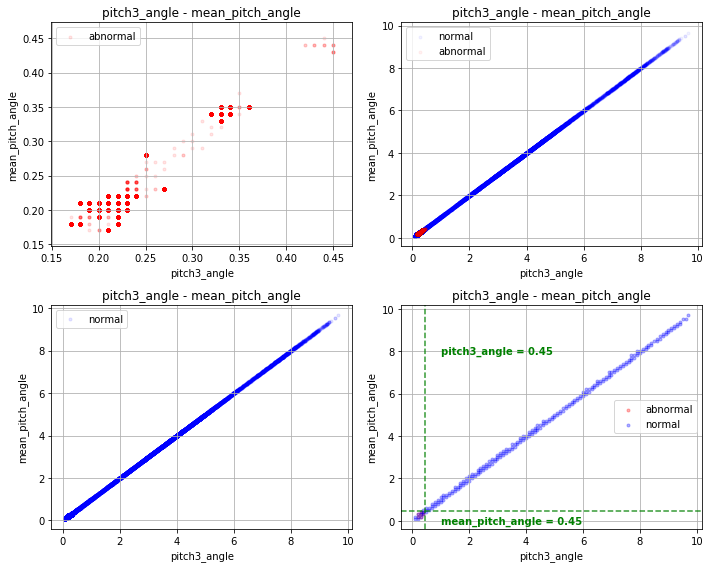

pitch3_angle > 1: 12519
mean_pitch_angle > 1: 12510
mean_pitch_angle > 1 且 pitch3_angle > 1: 12509


In [20]:
strong_rule_num(new15,'pitch3_angle','mean_pitch_angle',True,1,8,1,0)

373696
8
373696
194


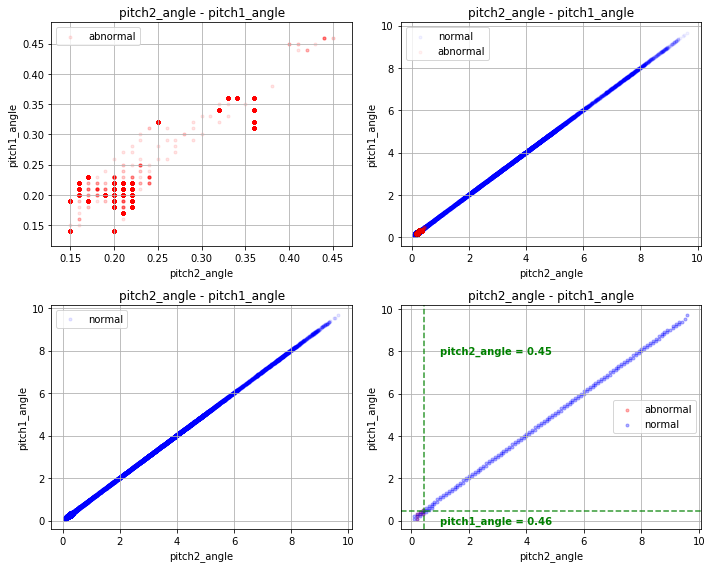

pitch2_angle > 1: 12475
pitch1_angle > 1: 12525
pitch1_angle > 1 且 pitch2_angle > 1: 12474


In [21]:
strong_rule_num(new15,'pitch2_angle','pitch1_angle',True,1,8,1,0)

# 四 所有规则总结
逐个剔除，发现有两个不能除去

In [22]:
new15[
    (new15['wind_speed']>2) |
    (new15['power']>2) |#10000
    (new15['environment_tmp']>2) |#5000
    (new15['pitch2_moto_tmp']>1) | (new15['pitch1_moto_tmp']>1) | (new15['pitch3_moto_tmp']>1) |# 60
    (new15['pitch3_angle']>1) | (new15['pitch2_angle']>1) | (new15['pitch1_angle']>1) | (new15['mean_pitch_angle']>1) # 20
    ].shape[0] 

19180

In [23]:
new15[
    (new15['power']>2)|
    (new15['environment_tmp']>2) 
    ].shape[0] 

19136

373696
316
373696
1478


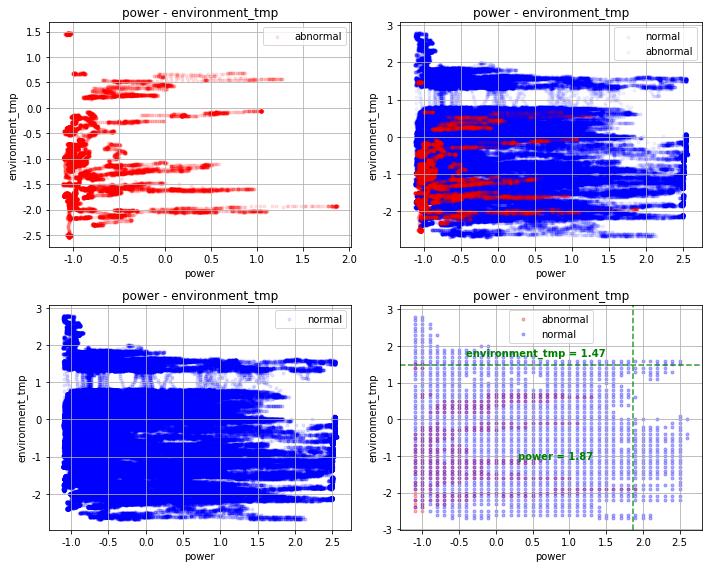

power > 2: 16581
environment_tmp > 2: 2555
environment_tmp > 2 且 power > 2: 0


In [24]:
strong_rule_num(new15,'power','environment_tmp',True,0.3,-1,-0.4,1.8)

# 五 效果

## 1 被过滤部分得分——\#15的训练集和测试集

In [25]:
new15w = new15[(new15['power']<=2) & (new15['environment_tmp']<=2)]
new15s = new15[(new15['power']>2) | (new15['environment_tmp']>2)]

In [26]:
def cal_strong_score(names,X,y_test):
    scores = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1-measure','Train time(s)','Test time(s)'],index=names)
    for name in names:
        y_pred = np.zeros((X.shape[0],1), dtype=np.int16 ) 
        scores.at[name,'Accuracy'] = accuracy_score(y_test, y_pred)
        scores.at[name,'Precision'] = precision_score(y_test, y_pred)
        scores.at[name,'Recall'] = recall_score(y_test, y_pred)
        scores.at[name,'F1-measure'] = f1_score(y_test, y_pred)
#         scores.at[name,'AUC'] = roc_auc_score(y_test, y_pred)
        scores.at[name,'Train time(s)'] = 0
        scores.at[name,'Test time(s)'] = 0
    return scores

In [27]:
cal_strong_score(['Strong Rule'],new15s.drop(columns=['label']), new15s["label"])

,Accuracy,Precision,Recall,F1-measure,Train time(s),Test time(s)
Strong Rule,1.000,0.000,0.000,0.000,0,0


## 2 不采用过滤手段

In [28]:
X,y = new15.drop(columns=['label']), new15[['power',"label",'environment_tmp']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

X_train.index

Int64Index([ 85505, 311807,  40720, 308318,  44372, 326091,  14351, 328222,
            305697, 119494,
            ...
            212038, 211543,  86293, 122579, 304137, 359783, 358083, 152315,
            117952, 305711],
           dtype='int64', length=261587)

In [29]:
def cal_model_scores(names, classifiers,X_train, y_train,X_test,y_test):
    y_train = y_train['label']
    y_test = y_test['label']
    scores = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1-measure','AUC','Train time(s)','Test time(s)'], index=names)
    for name, clf in zip(names, classifiers):
        time1 = time.time()
        clf.fit(X_train, y_train)
        time2 = time.time()
        y_pred = clf.predict(X_test)
        time3 = time.time()

        scores.at[name,'Accuracy'] = accuracy_score(y_test, y_pred)
        scores.at[name,'Precision'] = precision_score(y_test, y_pred)
        scores.at[name,'Recall'] = recall_score(y_test, y_pred)
        scores.at[name,'F1-measure'] = f1_score(y_test, y_pred)
        scores.at[name,'AUC'] = roc_auc_score(y_test, y_pred)

        scores.at[name,'Train time(s)'] = time2 - time1
        scores.at[name,'Test time(s)'] = time3 - time2

    return scores

In [30]:
names = ["Nearest Neighbors",
"Logistic Regression", 
"Decision Tree"
]

classifiers = [
    KNeighborsClassifier(n_jobs=-1,n_neighbors=3),
    LogisticRegression(n_jobs=-1,random_state=0,class_weight='balanced'), 
    DecisionTreeClassifier(random_state=0,class_weight='balanced')
]

In [31]:
scores15_balanced = cal_model_scores(names, classifiers,X_train, y_train,X_test,y_test)

In [32]:
scores15_balanced

,Accuracy,Precision,Recall,F1-measure,AUC,Train time(s),Test time(s)
Nearest Neighbors,0.995,0.973,0.945,0.959,0.972,2.400,36.617
Logistic Regression,0.874,0.320,0.859,0.467,0.867,21.615,0.015
Decision Tree,0.999,0.996,0.995,0.995,0.997,9.356,0.037


In [33]:
scores15_balanced - scores15

NameError: name 'scores15' is not defined

In [34]:
scores15 = cal_model_scores(names, classifiers,X_train, y_train,X_test,y_test)

In [35]:
scores15

,Accuracy,Precision,Recall,F1-measure,AUC,Train time(s),Test time(s)
Nearest Neighbors,0.995,0.973,0.945,0.959,0.972,2.818,37.876
Logistic Regression,0.874,0.320,0.859,0.467,0.867,20.039,0.012
Decision Tree,0.999,0.996,0.995,0.995,0.997,9.333,0.036


## 3 使用过滤后

In [36]:
def cal_all_score(names,classifiers,X_train, y_train,X_test,y_test):
    scores = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1-measure','AUC','Train time(s)','Test time(s)'], index=names)
    for name, clf in zip(names, classifiers):
        X_train_w = X_train[(X_train['power']<=2) & (X_train['environment_tmp']<=2)]
        X_train_s = X_train[(X_train['power']>2) | (X_train['environment_tmp']>2)]
        X_test_w = X_test[(X_test['power']<=2) & (X_test['environment_tmp']<=2)]
        X_test_s = X_test[(X_test['power']>2) | (X_test['environment_tmp']>2)]

        y_train_w = y_train[(y_train['power']<=2) & (y_train['environment_tmp']<=2)]
        y_train_s = y_train[(y_train['power']>2) | (y_train['environment_tmp']>2)]
        y_test_w = y_test[(y_test['power']<=2) & (y_test['environment_tmp']<=2)]
        y_test_s = y_test[(y_test['power']>2) | (y_test['environment_tmp']>2)]

        time1 = time.time()
        clf.fit(X_train_w, y_train_w['label'])
        time2 = time.time()
        y_test_w['y_pred'] = clf.predict(X_test_w)
        time3 = time.time()
        y_test_s['y_pred'] = 0
        y_pred = pd.concat([y_test_w,y_test_s])

        scores.at[name,'Accuracy'] = accuracy_score(y_pred['label'], y_pred['y_pred'])
        scores.at[name,'Precision'] = precision_score(y_pred['label'], y_pred['y_pred'])
        scores.at[name,'Recall'] = recall_score(y_pred['label'], y_pred['y_pred'])
        scores.at[name,'F1-measure'] = f1_score(y_pred['label'], y_pred['y_pred'])
        scores.at[name,'AUC'] = roc_auc_score(y_pred['label'], y_pred['y_pred'])

        scores.at[name,'Train time(s)'] = time2 - time1
        scores.at[name,'Test time(s)'] = time3 - time2

    return scores

In [37]:
scores15_with_strong = cal_all_score(names, classifiers,X_train, y_train,X_test,y_test)

In [38]:
scores15_with_strong

,Accuracy,Precision,Recall,F1-measure,AUC,Train time(s),Test time(s)
Nearest Neighbors,0.995,0.973,0.945,0.959,0.972,2.649,37.684
Logistic Regression,0.890,0.348,0.831,0.491,0.862,18.377,0.013
Decision Tree,1.000,0.997,0.997,0.997,0.998,8.311,0.039


## 4 前后对比

In [39]:
scores15_with_strong - scores15

,Accuracy,Precision,Recall,F1-measure,AUC,Train time(s),Test time(s)
Nearest Neighbors,0.000,0.000,0.000,0.000,0.000,-0.169,-0.193
Logistic Regression,0.015,0.028,-0.028,0.024,-0.005,-1.662,0.001
Decision Tree,0.000,0.001,0.002,0.001,0.001,-1.022,0.003
